# W2M5

이번 미션에서는 트위터 데이터를 받아와서 자주 나오는 단어를 word cloud로 출력합니다.

## Prepare
우선 주요 모듈을 다운로드 받습니다.

In [1]:
! pip install konlpy
! pip install wordcloud
! pip install nltk
! pip install pandas
! java -version
#import nltk
#nltk.download('all')

openjdk version "22.0.1" 2024-04-16
OpenJDK Runtime Environment Zulu22.30+13-CA (build 22.0.1+8)
OpenJDK 64-Bit Server VM Zulu22.30+13-CA (build 22.0.1+8, mixed mode, sharing)


다음으로는 X(전 트위터) 데이터를 다운로드 받습니다.

In [ ]:
! pwd
! curl -L -o ./sentiment140.zip\
  https://www.kaggle.com/api/v1/datasets/download/kazanova/sentiment140
! unzip sentiment140.zip

다음으로는 이번 미션에 필요한 모듈을 받아옵니다.

In [25]:
import requests
from bs4 import BeautifulSoup
from bs4.element import ResultSet, Tag
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud 
import nltk
import tqdm
from tabulate import tabulate
import csv
import time
import re

nltk.download("stopwords")

mp.set_start_method('fork', force=True) # setting multi-processing

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Extract and Transform
데이터를 csv로부터 읽고 단어단위로 변환합니다.

우선 멀티프로세싱을 위한 함수를 선언하고 정의합니다.

In [27]:
base_url = "https://www.etoos.com/teacher/Evaluate/default.asp?"
teacher_id_list = [200180, 200439]
page_range = 34
# -> 총 데이터 개수 = 선생 수 x 페이지 범위 x 한 페이지 당 개수 = 2 x 34 x 15 = 1020
teacher_prefix = "TEACHER_ID="
page_prefix = "&page="
path = "./data/"
f_name = 'review.csv'
csv_full_name = path + f_name
def getFullUrl(teacher_id:int, page:int)->str:
    global base_url
    url = base_url + teacher_prefix + str(teacher_id) + page_prefix + str(page)
    return url
review_list = []

with open(csv_full_name, "w", encoding="utf-8", newline="") as csv_file:
    writer = csv.writer(csv_file)
    # 헤더 작성
    writer.writerow(["teacher_name", "no", "text", "date"])

for teacher_id in teacher_id_list:
    review_list = [] # reset review list
    for page in range(1,page_range + 1):
        print("curr page:", page)
        # 너무 자주보내면 응답을 안 줌
        time.sleep(2)
        response = requests.get(getFullUrl(teacher_id=teacher_id, page=page))
        if response.status_code == 200:
            # 응답 성공
            # 한글 깨짐 방지 인코딩
            response.encoding = 'euc-kr'
            soup = BeautifulSoup(response.text, 'html.parser')
            # 첫 페이지면 선생님 이름 가져오기
            if page == 1:
                teacher_name = soup.select_one("div#TeacherLeftGnbEach a.tit").get_text(strip=True)
                print(teacher_name)
            # 리뷰가 적힌 행들 가져오기
            rows = soup.select('tbody > tr')
            for row in rows:
                # 등록 번호 찾기
                reg_num = row.select_one('td:nth-child(1)').get_text(strip=True)
                # BEST 수강 후기는 매 페이지마다 표시되므로 스킵
                if reg_num == "BEST": continue
                # 리뷰 내용 찾기
                review_text = row.select_one('td.wr_tit p.tit')
                ## 쓸데없는 정보 제거( new! 표시 )
                if review_text.span != None:
                    review_text.span.decompose()
                review_text = review_text.text.strip()
                # 등록 날짜 찾기
                date = row.select_one('td:nth-child(5)').get_text(strip=True)
                # 한 행 출력
                print(teacher_name, reg_num, review_text, date)
                # csv로 저장할 행 생성
                review = [teacher_name, reg_num, review_text, date]
                # 전체 리뷰에 추가
                review_list.append(review)
            # 파일로 저장
            with open(csv_full_name, "a", encoding="utf-8", newline="") as csv_file:
                writer = csv.writer(csv_file)
                # 데이터 작성
                writer.writerows(review_list)

curr page: 1
정승제 선생님
정승제 선생님 4195 들으면 절대 후회 안 함. 안 들으면 후회함. 2025.01.16
정승제 선생님 4194 감사합니다 2025.01.16
정승제 선생님 4193 저의 수학 구세주 승제쌤 2025.01.16
정승제 선생님 4192 굳굳굳굳 2025.01.15
정승제 선생님 4191 수능을 준비하며.. 2025.01.15
정승제 선생님 4190 생선님을 중3 때 알았더라면… 2025.01.15
정승제 선생님 4189 믿듣정 2025.01.14
정승제 선생님 4188 정승제가 갓승제인 이유 2025.01.14
정승제 선생님 4187 수강 후기 2025.01.14
정승제 선생님 4186 공통수학1 선생님 2025.01.13
정승제 선생님 4185 완벽한 강의 2025.01.13
정승제 선생님 4184 빈 개념 채우기 2025.01.13
정승제 선생님 4183 꽤 많은 도움이 됩니다 2025.01.11
정승제 선생님 4182 역시 갓승제 2025.01.11
정승제 선생님 4181 만족스러운 강의였습니다 2025.01.11
curr page: 2
정승제 선생님 4180 언제 어디서든 집중해서 들을 수 있는 강의 2025.01.10
정승제 선생님 4179 1년동안 2025.01.10
정승제 선생님 4178 여러분이 도형에서 닮음을 못 찾는 이유? 2025.01.09
정승제 선생님 4177 chatgpt보다 빠른 질문 답변 2025.01.09
정승제 선생님 4176 생선님 너무 완벽합니다 2025.01.09
정승제 선생님 4175 정말 좋은데요? 2025.01.08
정승제 선생님 4174 수강 후기 2025.01.08
정승제 선생님 4173 수학의 신 2025.01.08
정승제 선생님 4172 깔끔한 개념 설명 2025.01.07
정승제 선생님 4171 재밌다 2025.01.07
정승제 선생님 4170 기초도 모르면? 2025.01.07
정승제 선생님 4169 보는 재미가 열의와 열정을 만들어주는, 2025.01.04
정승제 선생님

KeyboardInterrupt: 

In [20]:
import konlpy
from konlpy.tag import Okt

def work(data):
    # set tools to transform from sentence to refined word
    okt = Okt()
    #stop_words = nltk.corpus.stopwords.words('korean')
    print(mp.current_process().pid, len(data))

    gtokens = []
    
    #transform
    for sentence in tqdm.tqdm(data["text"], desc="tokenizing"):
        text = re.sub("[^가-힣a-zA-Z0-9]+", " ", sentence)  # 특수문자 제거
        tokens = okt.nouns(text)
        #tokens = [word for word in tokens if not word in stop_words]
        [gtokens.append(t) for t in tokens]
    return pd.Series(gtokens)

다음으로는 메인 프로세스에서 데이터를 읽고, 나눠서 멀티 프로세싱으로 데이터를 변환합니다. 변환은 간단하게 긍정, 부정 세트로 나눠서 2개의 프로세스로 진행합니다.

멀티 프로세싱으로 인해 진행률이 다소 이상하게 나올 수 있습니다

In [21]:
if __name__ == "__main__":
    # extract: read csv from disk
    data = pd.read_csv("./data/review.csv",
    #                    encoding='utf-8',
                        )

    # transform: tokenize the sentences
    data0 = data[data["teacher_name"] == "정승제 선생님"]   # negative set
    data1 = data[data["teacher_name"] == "주혜연 선생님"]   # positive set
    
    data = [data0, data1]

    data0 = work(data0)
    data1 = work(data1)

    res = []
    res.append(data0)
    res.append(data1)

    #with mp.Pool(processes=2) as p:
    #   res = p.map(work, data)
    

"""
    data0 = [data0[i:i+BATCH_SIZE] for i in range(0, len(data0), BATCH_SIZE)]
    data4 = [data4[i:i+BATCH_SIZE] for i in range(0, len(data4), BATCH_SIZE)]
    data = data0
    data.extend(data4)
    print("!", len(data))
    with mp.Pool(processes=WORK_CNT) as p:
        res = p.map(work, data)
    print("!!")
    data = [[],[]]
    data[0] += [item for sublist in res[:len(res)//2] for item in sublist]
    data[1] += [item for sublist in res[len(res)//2:] for item in sublist]
    res = data
    print("!!!")
"""

27242 8415


tokenizing: 100%|██████████| 8415/8415 [00:02<00:00, 3495.24it/s]


27242 8925


tokenizing: 100%|██████████| 8925/8925 [00:02<00:00, 3057.84it/s]


'\n    data0 = [data0[i:i+BATCH_SIZE] for i in range(0, len(data0), BATCH_SIZE)]\n    data4 = [data4[i:i+BATCH_SIZE] for i in range(0, len(data4), BATCH_SIZE)]\n    data = data0\n    data.extend(data4)\n    print("!", len(data))\n    with mp.Pool(processes=WORK_CNT) as p:\n        res = p.map(work, data)\n    print("!!")\n    data = [[],[]]\n    data[0] += [item for sublist in res[:len(res)//2] for item in sublist]\n    data[1] += [item for sublist in res[len(res)//2:] for item in sublist]\n    res = data\n    print("!!!")\n'

In [ ]:
fm.findSystemFonts()

## Print Result
변환 결과를 word cloud 이미지로 출력합니다

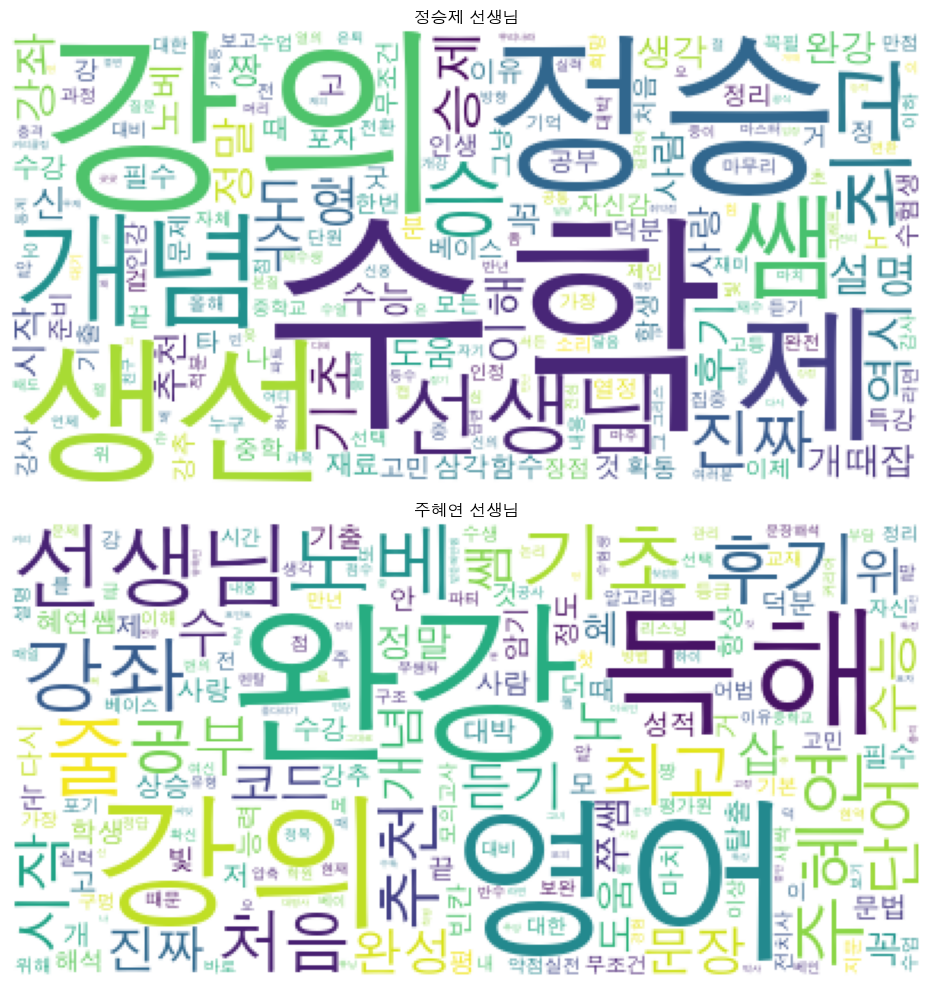

In [32]:
plt.rcParams['font.family'] = "AppleGothic"

wc = WordCloud(background_color="white", font_path="AppleGothic")
wc2 = WordCloud(background_color="white", font_path="AppleGothic")

cloud1 = wc.generate_from_frequencies(pd.Series(res[0]).value_counts())
cloud2 = wc2.generate_from_frequencies(pd.Series(res[1]).value_counts())

fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # 1행 2열 서브플롯

axes[0].imshow(cloud1)
axes[0].axis('off')
axes[0].set_title('정승제 선생님')

axes[1].imshow(cloud2)
axes[1].axis('off')
axes[1].set_title('주혜연 선생님')

plt.tight_layout()
plt.show()
